In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn keras keras-tuner tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

import keras_tuner as kt
import os

In [ ]:
df = pd.read_csv('oversampled_cities.csv')
df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
0,Bengaluru,31.44,70.46,3.03,15.85,10.27,27.73,1.22,1.94,17.98,2.41,17.84,60.0
1,Bengaluru,43.31,94.45,3.79,23.38,24.16,13.53,0.98,6.97,53.12,0.50,1.98,100.0
2,Bengaluru,38.15,87.04,4.96,26.49,27.94,12.13,0.93,7.97,55.40,0.56,2.03,91.0
3,Bengaluru,29.66,72.55,4.54,24.72,25.90,11.06,0.90,7.25,39.28,0.38,3.03,78.0
4,Bengaluru,24.15,77.96,4.75,19.78,22.33,10.48,0.86,7.01,31.85,0.35,3.40,77.0


In [ ]:
# Check for missing values
print(df.isnull().sum())
# Basic statistics
df.describe()

City       0
PM2.5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
AQI        0
dtype: int64


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
count,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000,13167.000000
mean,58.482829,117.780002,17.441233,34.041508,37.063144,26.398999,0.992239,10.286997,39.544980,3.550332,9.181230,136.097875
std,52.041439,87.404947,23.106775,20.841278,33.729114,19.266894,1.140534,6.691439,20.344116,5.568415,10.862626,91.226831
min,2.000000,0.210000,0.440000,0.170000,0.000000,0.120000,0.000000,0.970000,0.240000,0.000000,0.000000,23.000000
25%,27.863492,58.408769,6.187305,18.515185,18.308218,12.830000,0.600000,5.879219,25.882999,0.640000,1.910000,76.000000
50%,43.413828,95.630000,9.510000,29.860000,26.923390,21.716502,0.820000,8.690000,35.740000,1.760000,5.930000,106.000000
75%,68.075000,147.085661,16.882647,43.668736,42.130000,34.654260,1.070000,12.802550,50.060000,4.090000,11.700695,157.408293
max,685.360000,796.880000,221.030000,162.500000,293.100000,207.140000,30.440000,71.560000,257.730000,64.440000,103.000000,716.000000


In [ ]:
X = df.drop(['City', 'AQI'], axis=1).values
y = df['AQI'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LSTM expects 3D input: (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [ ]:
def build_lstm_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        input_shape=(X_lstm.shape[1], X_lstm.shape[2]),
        return_sequences=False,
        kernel_regularizer=regularizers.l2(hp.Choice('l2', [0.0, 1e-4, 1e-3]))
    ))
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_mae',
    max_trials=15,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='lstm_aqi_regression'
)

tuner.search(X_lstm, y, epochs=20, validation_split=0.2, verbose=1,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)

Trial 15 Complete [00h 00m 44s]
val_mae: 108.49136352539062

Best val_mae So Far: 15.201203346252441
Total elapsed time: 00h 10m 03s
Best hyperparameters: {'units': 64, 'l2': 0.0001, 'dropout': 0.30000000000000004, 'lr': 0.01}


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

histories = []
fold_metrics = []
best_val_mae = float('inf')
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_lstm, y)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X_lstm[train_idx], X_lstm[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build model with best hyperparameters
    model = build_lstm_model(best_hp)

    # Early stopping
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=best_hp.values.get('batch_size', 32),
        callbacks=[es],
        verbose=1
    )
    histories.append(history)

    # Predict
    y_pred = model.predict(X_val).flatten()

    # Metrics
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    fold_metrics.append({
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'y_val': y_val,
        'y_pred': y_pred
    })

    # Save best model
    val_mae = min(history.history['val_mae'])
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model = model
        model.save('best_lstm_aqi_model.h5')


--- Fold 1 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 20040.0820 - mae: 110.3396 - val_loss: 5502.8267 - val_mae: 40.1441
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4969.4844 - mae: 38.6116 - val_loss: 2678.9553 - val_mae: 27.4261
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2890.3833 - mae: 29.8819 - val_loss: 1527.7750 - val_mae: 21.2819
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1633.5282 - mae: 23.5875 - val_loss: 1020.6801 - val_mae: 18.0940
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1266.1993 - mae: 21.3941 - val_loss: 782.6858 - val_mae: 16.5476
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1153.7142 - mae: 21.1720 - val_loss: 646.7468 - val_mae: 15.4115
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 949.9959 - mae: 19.5740 - val_loss: 567.9700 - val_mae: 14.8235
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 879.3901 - mae: 19.3108 - val_loss: 539.1354 - val_mae: 14.3892
Epoch 9


--- Fold 2 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 19521.7969 - mae: 109.6002 - val_loss: 5604.1035 - val_mae: 39.6506
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4550.5557 - mae: 37.3636 - val_loss: 2896.7437 - val_mae: 27.9339
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2637.3301 - mae: 28.4213 - val_loss: 1770.0177 - val_mae: 22.3420
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1584.4222 - mae: 23.3716 - val_loss: 1216.4011 - val_mae: 19.2032
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1040.6437 - mae: 20.5544 - val_loss: 954.0178 - val_mae: 17.3630
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1042.0232 - mae: 20.2534 - val_loss: 800.8864 - val_mae: 16.1301
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 901.6958 - mae: 19.4330 - val_loss: 713.7270 - val_mae: 15.7171
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 851.8243 - mae: 18.7102 - val_loss: 687.4818 - val_mae: 15.7400
Epoch 9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 18905.4219 - mae: 107.7390 - val_loss: 5998.9082 - val_mae: 41.7439
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4746.8042 - mae: 38.1125 - val_loss: 2977.7441 - val_mae: 28.1498
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2648.3308 - mae: 28.3029 - val_loss: 1724.0430 - val_mae: 21.8064
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1675.4398 - mae: 23.7758 - val_loss: 1181.8036 - val_mae: 18.9752
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1264.9213 - mae: 21.4446 - val_loss: 902.0392 - val_mae: 17.3527
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 995.0850 - mae: 19.7584 - val_loss: 746.9297 - val_mae: 16.1521
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 853.7604 - mae: 18.8479 - val_loss: 663.2635 - val_mae: 15.3192
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 874.8053 - mae: 19.0367 - val_loss: 629.7501 - val_mae: 15.0057
Epoch 9/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 20274.5020 - mae: 111.1444 - val_loss: 5363.4233 - val_mae: 39.8069
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4750.7578 - mae: 37.6769 - val_loss: 2567.6873 - val_mae: 27.0805
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2570.5129 - mae: 27.8623 - val_loss: 1458.5802 - val_mae: 21.1018
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1608.5009 - mae: 23.4959 - val_loss: 997.2485 - val_mae: 18.2367
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1282.6586 - mae: 21.4592 - val_loss: 800.9942 - val_mae: 16.8727
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1220.8049 - mae: 20.7385 - val_loss: 677.9150 - val_mae: 16.3457
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1051.3921 - mae: 20.0833 - val_loss: 601.9898 - val_mae: 15.3945
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 854.1108 - mae: 18.8346 - val_loss: 558.8000 - val_mae: 15.2101
Epoch 9

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 20357.3633 - mae: 111.3700 - val_loss: 5390.3477 - val_mae: 39.5671
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4861.8496 - mae: 38.0729 - val_loss: 2674.2659 - val_mae: 27.1259
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2515.8921 - mae: 28.0295 - val_loss: 1584.4694 - val_mae: 21.3113
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1591.2959 - mae: 23.3500 - val_loss: 1110.9574 - val_mae: 18.5053
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1168.8019 - mae: 20.8959 - val_loss: 916.6436 - val_mae: 16.9954
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 997.7643 - mae: 20.0519 - val_loss: 796.0286 - val_mae: 16.5718
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 913.8791 - mae: 19.3768 - val_loss: 729.1484 - val_mae: 16.0495
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 824.1663 - mae: 18.7560 - val_loss: 688.9235 - val_mae: 15.9286
Epoch 9/

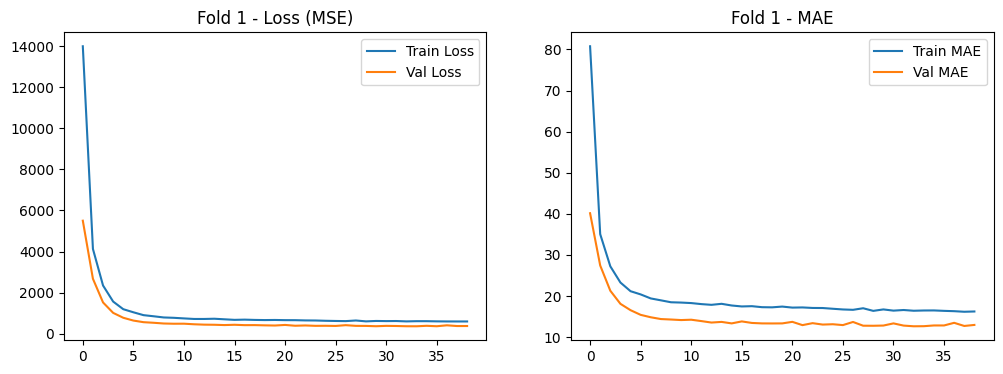

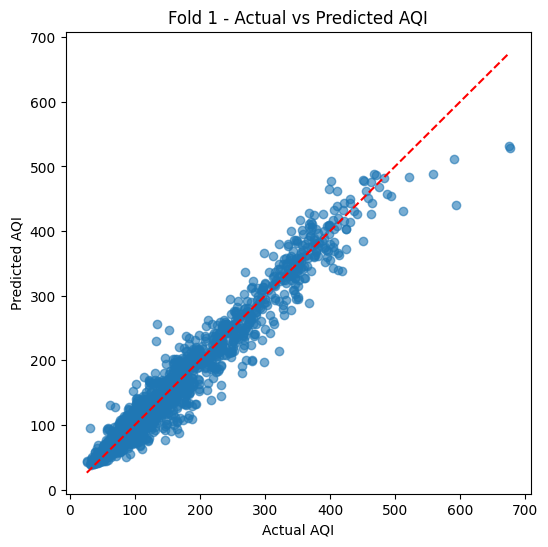

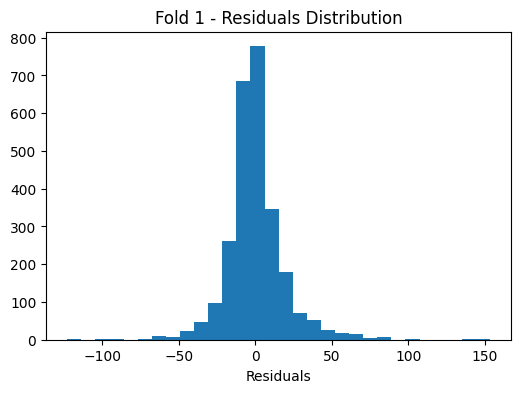

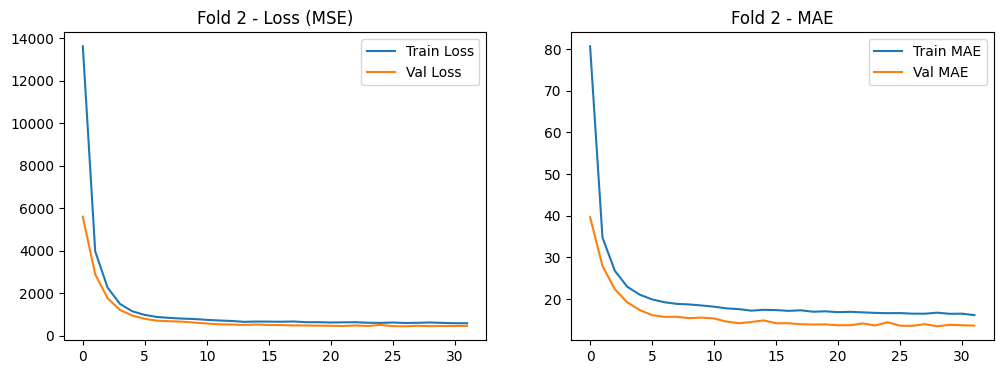

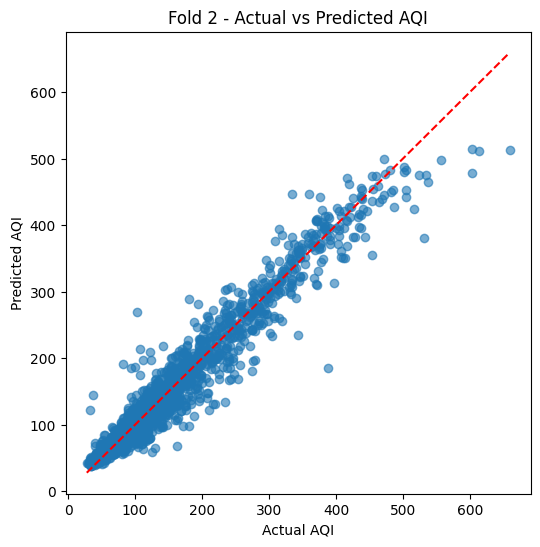

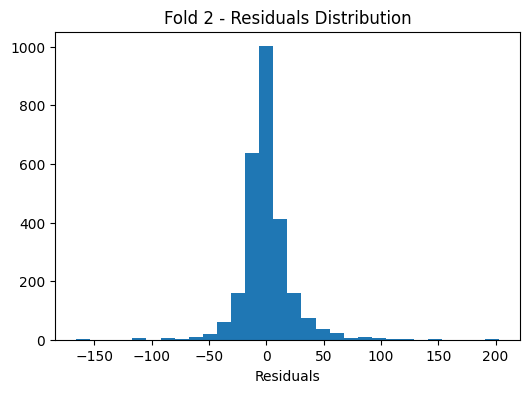

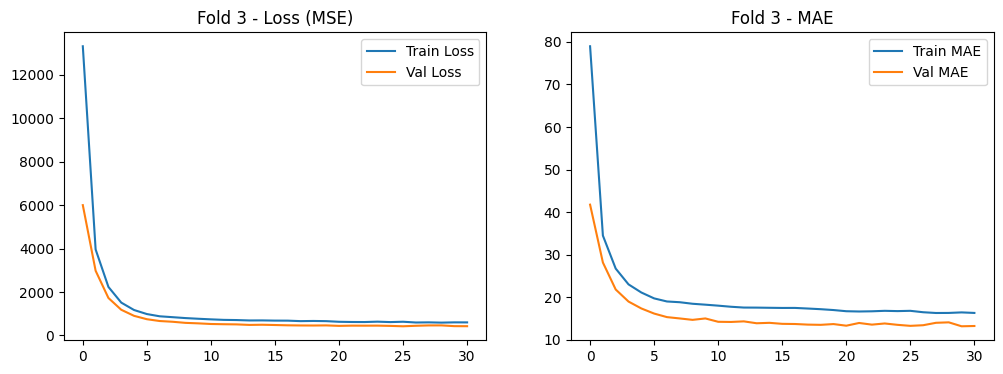

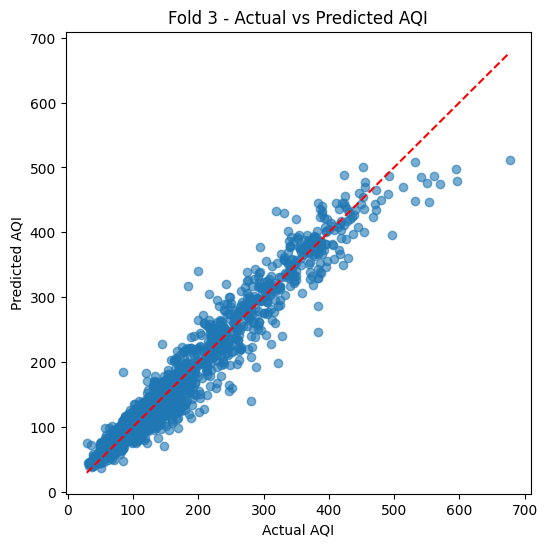

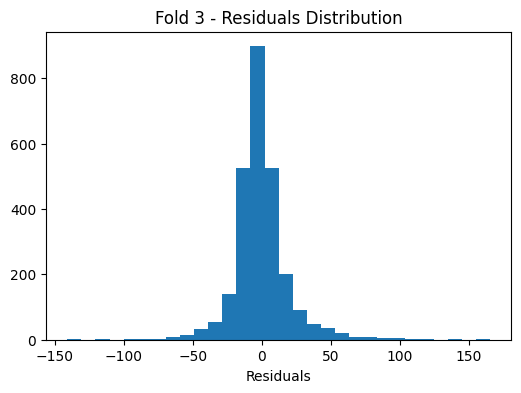

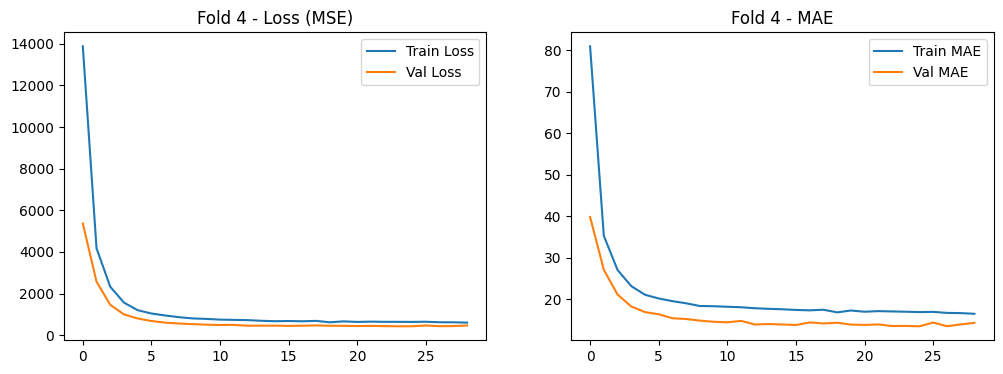

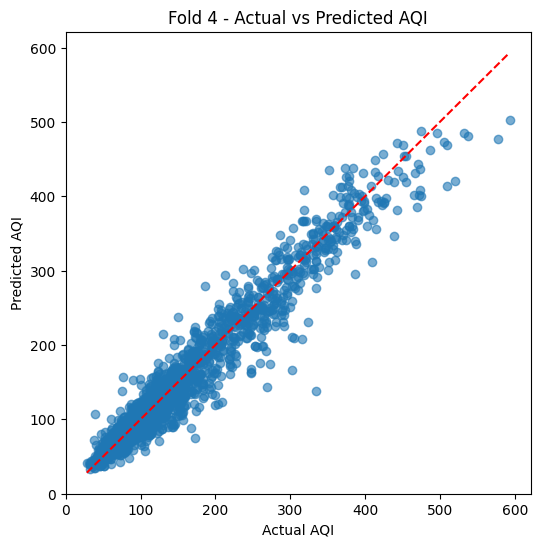

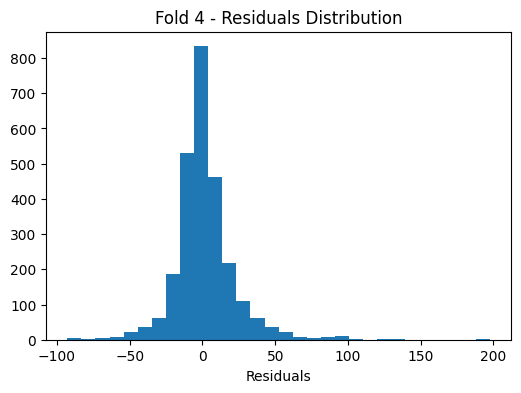

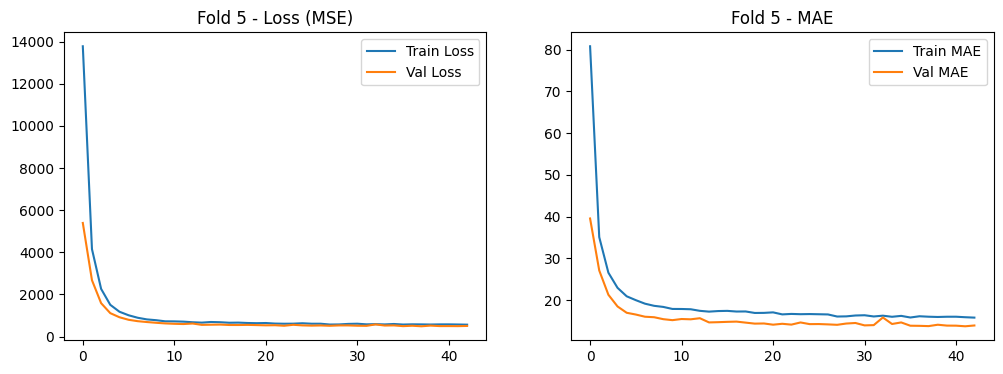

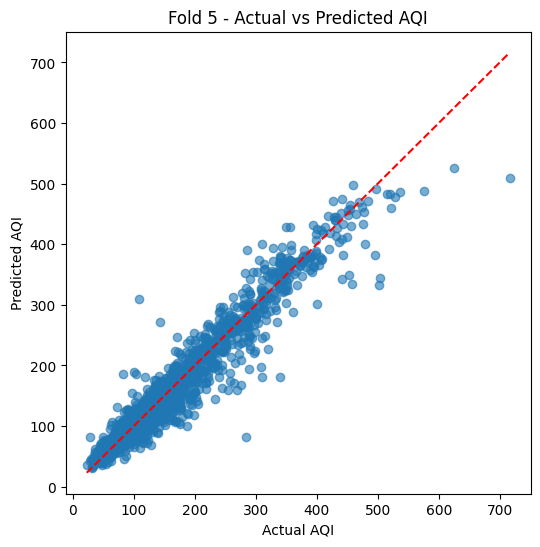

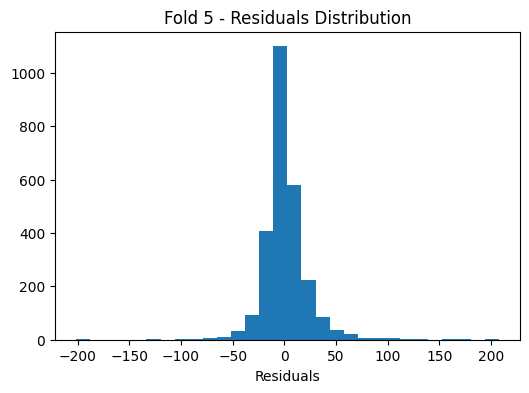

In [ ]:
for i, (history, metrics) in enumerate(zip(histories, fold_metrics)):
    # Loss & MAE
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i+1} - Loss (MSE)')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'Fold {i+1} - MAE')
    plt.legend()
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(6,6))
    plt.scatter(metrics['y_val'], metrics['y_pred'], alpha=0.6)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'Fold {i+1} - Actual vs Predicted AQI')
    plt.plot([metrics['y_val'].min(), metrics['y_val'].max()], [metrics['y_val'].min(), metrics['y_val'].max()], 'r--')
    plt.show()

    # Residuals
    plt.figure(figsize=(6,4))
    plt.hist(metrics['y_val'] - metrics['y_pred'], bins=30)
    plt.xlabel('Residuals')
    plt.title(f'Fold {i+1} - Residuals Distribution')
    plt.show()

In [ ]:
# Aggregate metrics
maes = [m['mae'] for m in fold_metrics]
mses = [m['mse'] for m in fold_metrics]
r2s = [m['r2'] for m in fold_metrics]

print(f'Average MAE: {np.mean(maes):.4f} ± {np.std(maes):.4f}')
print(f'Average MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}')
print(f'Average R2: {np.mean(r2s):.4f} ± {np.std(r2s):.4f}')

Average MAE: 13.3646 ± 0.3949
Average MSE: 430.8220 ± 38.8606
Average R2: 0.9481 ± 0.0054
